In [32]:
import ijson
import itertools
import random
import numpy as np
import sys, os
import pandas as pd 
import torch
from torchsummary import summary
from torchtext import data
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, TensorDataset,DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
from apex import amp
import shutil
import time
import matplotlib.pyplot as plt
import tensorflow as tf
%load_ext autoreload
%autoreload 2
%matplotlib inline

SEED = 7219
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Import transformers specific packages
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  BertForSequenceClassification, BertForTokenClassification
from transformers import AdamW,get_linear_schedule_with_warmup, pipeline

In [34]:
# Import package for data parallelism to train on multi-GPU machines
from parallel import DataParallelModel, DataParallelCriterion

In [35]:
# Set the device and empty cache 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
device

device(type='cuda')

- Add tensorboard summaries for monitoring training 
- Add accuracy, F1 score, log loss metric calculations
- Add architectural layers (freeze BERT layers, add new layers)
- Create pipeline


In [36]:
# Class for model training and inference
class Bert_Model():
    def __init__(self,train_df,test_df,bert_model_name,bert_model_path,
                tokenizer,
                max_seq_length=128,seed=1234):
        
        if max_seq_length > tokenizer.max_model_input_sizes[bert_model_name]:
            print("Max sequence length specified > 512!!... resetting to 128")
            print("If you don't want this then set max_seq_length to <= 512")
            self._MAX_SEQUENCE_LENGTH = 128
        else:
            self._MAX_SEQUENCE_LENGTH = max_seq_length
        self._SEED = seed
        self._WORK_DIR = "/root/models/Tranformer_based/workingdir/"
        self._bert_model_path=bert_model_path
        self._bert_model_name=bert_model_name
        self._train_data=train_df
        self._test_size=test_df
        self._tokenizer = tokenizer
        self._training_stats = []

    def tokenize(self,text_array):
        ''' Returns tokenized IDs and attention mask
        The transformers encode_plus method returns the following:
        {
        input_ids: list[int],
        token_type_ids: list[int] if return_token_type_ids is True (default)
        attention_mask: list[int] if return_attention_mask is True (default)
        overflowing_tokens: list[int] if a ``max_length`` is specified and return_overflowing_tokens is True
        num_truncated_tokens: int if a ``max_length`` is specified and return_overflowing_tokens is True
        special_tokens_mask: list[int] if ``add_special_tokens`` if set to ``True`` and return_special_tokens_mask is True
        }'''
        all_tokens=[]
        all_attention_mask=[]
        for i,text in enumerate(tqdm_notebook(text_array)):
            encoded = tokenizer.encode_plus(
                           text, 
                           add_special_tokens=True,
                           max_length=self._MAX_SEQUENCE_LENGTH,
                           pad_to_max_length=True)
            tokens = torch.tensor(encoded['input_ids'])
            attention_mask = torch.tensor(encoded['attention_mask'])
            all_tokens.append(tokens)
            all_attention_mask.append(attention_mask)
        return all_tokens,all_attention_mask
     
    def initialize_model_for_training(self,dataset_len,EPOCHS=1,model_seed=21000,lr=2e-5,batch_size=32,
                                      accumulation_steps=2):
        # Setup model parameters
        np.random.seed(model_seed)
        torch.manual_seed(model_seed)
        torch.cuda.manual_seed(model_seed)
        torch.backends.cudnn.deterministic = True

        # Empty cache
        torch.cuda.empty_cache()
        model = BertForSequenceClassification.from_pretrained(self._bert_model_path,
                                                              cache_dir=None,
                                                              num_labels=2,
                                                              output_attentions = False, 
                                                              output_hidden_states = False)
        
        model = model.to(device)
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]
        num_train_optimization_steps = int(EPOCHS*dataset_len/batch_size/accumulation_steps)
        optimizer = AdamW(optimizer_grouped_parameters, lr=lr,eps=1e-8,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
        scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
        model, optimizer = amp.initialize(model,optimizer,opt_level="O1",verbosity=0)
        ### Parallel GPU processing
        model = DataParallelModel(model)
        criterion = nn.CrossEntropyLoss()
        model = model.train()
        model.zero_grad()
        optimizer.zero_grad()
        return model,optimizer,scheduler,criterion,EPOCHS
    
    def run_training(self,model,train_dataLoader,valid_dataLoader,optimizer,scheduler,criterion,
                     EPOCHS=1,batch_size=32,accumulation_steps=20,evaluation_steps=80,pred_thres=0.5,
                     logdir='./logs'):
        # Data Structure for training statistics
        training_stats=[]
        validation_stats=[]
        
        tr_loss = 0.
        tr_accuracy = 0.
         
        tq = tqdm_notebook(range(EPOCHS),total=EPOCHS,leave=False)
        global_step = 0
        for epoch in tq:
            print("--Training--")
            tk0 = tqdm_notebook(enumerate(train_dataLoader),total=len(train_dataLoader),leave=True)
            for step,(x_batch,attn_mask,y_batch) in tk0:
                outputs = model(x_batch.to(device), 
                                token_type_ids=None, 
                                attention_mask=attn_mask.to(device), 
                                labels=y_batch.to(device))
                y_pred = outputs[1]
                
                # Parallel GPU processing
                parallel_loss_criterion = DataParallelCriterion(criterion)
            
#                 loss = criterion(y_pred,y_batch.to(device)) / accumulation_steps
                loss = parallel_loss_criterion(y_pred,y_batch.to(device))/accumulation_steps
    
                with amp.scale_loss(loss,optimizer) as scaled_loss:
                    scaled_loss.backward()
#                     loss.backward()
                tk0.set_postfix(step=global_step+1,loss=loss.item()) # display running loss
    
                tr_loss += loss.item()
                acc = torch.mean(((torch.sigmoid(y_pred[:,1])>pred_thres) == (y_batch>pred_thres).to(device)).to(torch.float)).item()/len(train_dataLoader)
                tr_accuracy += acc
                if (step+1) % accumulation_steps == 0:          # Wait for several backward steps
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip the norm to 1.0 to prevent exploding gradients
                    optimizer.step()                            # Now we can do an optimizer step
                    scheduler.step()
                    model.zero_grad()
                    global_step+=1
                    training_stats.append(
                            {
                                'step': global_step,
                                'train_loss': tr_loss/global_step,
                                'train_acc': tr_accuracy/global_step,
                            })
                    # Write training stats to tensorboard
                    self.summaryWriter("train",loss.item(),acc,global_step+1,logdir)            
                    # Run evaluation when no gradients are accumulated
                    if (step+1) % evaluation_steps ==0:
                        print("--I-- Running Validation")
                        eval_loss,eval_accuracy=self.run_eval(model,valid_dataLoader,global_step)
                        validation_stats.append(
                            {
                                'step': global_step,
                                'valid_loss': eval_loss,
                                'Training Accuracy': eval_accuracy,
                            })
                        # Write training stats to tensorboard
                        self.summaryWriter("eval",eval_loss,eval_accuracy,global_step,logdir)
            tq.set_postfix(train_loss=tr_loss/(global_step+1),train_accuracy=tr_accuracy/global_step)
        return model,training_stats,validation_stats
    
    def run_eval(self,model,valid_dataLoader,global_step):
        avg_loss = 0.
        eval_accuracy = 0.
        eval_loss = 0.
        nb_eval_steps = 0
        lossf=None
        tk0 = tqdm_notebook(enumerate(valid_dataLoader),total=len(valid_dataLoader),leave=True)
        for step,(x_batch, attn_mask,y_batch) in tk0:
            model.eval()
            with torch.no_grad():
                outputs = model(x_batch.to(device), 
                                token_type_ids=None, 
                                attention_mask=attn_mask.to(device), 
                                labels=y_batch.to(device))
            loss, y_pred = outputs
            loss = criterion(y_pred,y_batch.to(device))
            y_pred = y_pred.detach().cpu().numpy()
            label_ids = y_batch.to('cpu').numpy()
            tmp_eval_accuracy = self.flat_accuracy(y_pred, label_ids)
            if lossf:
                lossf = 0.98*lossf+0.02*loss.item()
            else:
                lossf = loss.item()
            # Accumulate the total accuracy.
            eval_loss += lossf/len(valid_dataLoader)
            eval_accuracy += tmp_eval_accuracy/len(valid_dataLoader)
            nb_eval_steps += 1
        avg_loss = eval_loss/nb_eval_steps
        avg_accuracy = eval_accuracy/nb_eval_steps
        tk0.set_postfix(step=global_step,avg_loss=avg_loss,avg_accuracy=avg_accuracy)
        return avg_loss,avg_accuracy

     # Function to calculate the accuracy of predictions vs labels
    def flat_accuracy(self,preds,labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat)
    
    def summaryWriter(self,name,loss,acc,n_iter,logdir):
        # Writer will output to ./runs/ directory by default
        writer = SummaryWriter(logdir)
        writer.add_scalar('Loss/'+name,loss,n_iter)
        writer.add_scalar('Accuracy/'+name,acc,n_iter)
        writer.close()

In [37]:
class CreateDataset(Dataset):
    def __init__(self,data,atten_mask,labels):
        self._dataset = [[data[i],atten_mask[i],labels.values[i]] for i in range(0,len(data))]
    
    def __len__(self):
        return len(self._dataset)

    def __getitem__(self,idx):
        return self._dataset[idx]


In [38]:
# Define constants and paths

seed = 7843
bert_model_name = "bert-base-uncased"
# Convert TF checkpoint to pytorch chckpoint and then use as input to class object
bert_model_path = "/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/"

# data_path = "/Users/suhasgupta/w251/mids-w251-final-project/data/nlp.cs.princeton.edu/SARC/2.0/pol/"
data_path = "/root/data/nlp.cs.princeton.edu/SARC/2.0/files/"
work_dir = "/root/models/Tranformer_based/workingdir/"

tokenizer = BertTokenizer.from_pretrained(bert_model_name, cache_dir=None,do_lower_case=True)
max_seq_len = 128

# Load and check the dataset from files on disk 
train_file_name = data_path+'small_train.csv'
test_file_name  = data_path+'small_test.csv'
# train_file_name = data_path+'balanced_train.csv'
# test_file_name  = data_path+'balanced_test.csv'


all_train_df = pd.read_csv(train_file_name)
test_df = pd.read_csv(test_file_name)

# Create a train, valid split
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_train_df, test_size=0.2,random_state=seed)

train_data   = train_df.text.fillna("DUMMY_VALUE")
train_labels = train_df.label
valid_data  = valid_df.text.fillna("DUMMY_VALUE")
valid_labels = valid_df.label
test_data  = test_df.text.fillna("DUMMY_VALUE")
test_labels = test_df.label

train_size,valid_size,test_size = len(train_df),len(valid_df),len(test_df)
print(train_size,valid_size,test_size)

7999 2000 9999


In [39]:
# Create a model object 
bert_model1=Bert_Model(train_df=train_df,
                      test_df=test_df,
                      bert_model_name=bert_model_name,
                      bert_model_path=bert_model_path,
                      tokenizer=tokenizer,
                      max_seq_length=max_seq_len)

In [40]:
%timeit
print("--Tokenizing--")
train_data_tokenized,train_attention_mask = bert_model1.tokenize(train_data)
valid_data_tokenized,valid_attention_mask = bert_model1.tokenize(valid_data)
test_data_tokenized,test_attention_mask = bert_model1.tokenize(test_data)


--Tokenizing--


In [11]:
# # save to files for later use
# TOKEN_DATA_PATH = '/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/tokenized/'
# with open('/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/tokenized/train_data_tokenized.txt', 'wb') as fp:
#     pickle.dump(train_data_tokenized, fp)
# with open('train_attention_mask.txt', 'wb') as fp:
#     pickle.dump(train_attention_mask, fp)    
# with open('valid_data_tokenized.txt', 'wb') as fp:
#     pickle.dump(valid_data_tokenized, fp)
# with open('valid_attention_mask.txt', 'wb') as fp:
#     pickle.dump(valid_attention_mask, fp)
# with open('test_data_tokenized.txt', 'wb') as fp:
#     pickle.dump(test_data_tokenized, fp)
# with open('test_attention_mask.txt', 'wb') as fp:
#     pickle.dump(test_attention_mask, fp)

In [12]:
# # read back tokenized data
# TOKEN_DATA_PATH = '/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/tokenized/'
# with open(TOKEN_DATA_PATH+'train_data_tokenized.txt', 'rb') as fp:
#     train_data_tokenized=pickle.load(fp)
# with open(TOKEN_DATA_PATH+'train_attention_mask.txt', 'rb') as fp:
#     train_attention_mask=pickle.load(fp)    
# with open(TOKEN_DATA_PATH+'valid_data_tokenized.txt', 'rb') as fp:
#     valid_data_tokenized=pickle.load(fp)
# with open(TOKEN_DATA_PATH+'valid_attention_mask.txt', 'rb') as fp:
#     valid_attention_mask=pickle.load(fp)
# with open(TOKEN_DATA_PATH+'test_data_tokenized.txt', 'rb') as fp:
#     test_data_tokenized=pickle.load(fp)
# with open(TOKEN_DATA_PATH+'test_attention_mask.txt', 'rb') as fp:
#     test_attention_mask=pickle.load(fp)

In [13]:
train_dataset = CreateDataset(train_data_tokenized,train_attention_mask,train_labels)
train_sampler = RandomSampler(train_dataset)
valid_dataset = CreateDataset(valid_data_tokenized,valid_attention_mask,valid_labels)
valid_sampler = RandomSampler(valid_dataset)

In [41]:
# # Parameters for cloud GPU
# train_params = {'batch_size': 48,
#           'shuffle': False,
#           'num_workers': 16}
# valid_params = {'batch_size': 48,
#           'shuffle': False,
#           'num_workers': 16}

# # Parameters for Suhas's Mac
# train_params = {'batch_size': 128,
#           'shuffle': False,
#           'num_workers': 16}
# valid_params = {'batch_size': 128,
#           'shuffle': False,
#           'num_workers': 16}

# Parameters for local GPU
train_params = {'batch_size': 32,
          'shuffle': False,
          'num_workers': 16}
valid_params = {'batch_size': 32,
          'shuffle': False,
          'num_workers': 16}

max_epochs = 5
accumulation_steps = 10
evaluation_steps   = 80

# print("Expected number of batches:", int(len(train_data_tokenized)/params['batch_size']))
train_dataLoader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler,batch_size=train_params['batch_size'],
                                         shuffle=train_params['shuffle'],
                                         num_workers=train_params['num_workers'],
                                         pin_memory=False,drop_last=True)
valid_dataLoader = torch.utils.data.DataLoader(valid_dataset,sampler=valid_sampler,batch_size=valid_params['batch_size'],
                                         shuffle=valid_params['shuffle'],
                                         num_workers=valid_params['num_workers'],
                                         pin_memory=False,drop_last=True)
print("Generated number of training batches:%d" %len(train_dataLoader))
print("Generated number of validation batches:%d" %len(valid_dataLoader))
print("Number of training steps:",len(train_dataLoader)*max_epochs/accumulation_steps)
print("Number of validation steps:",len(train_dataLoader)*max_epochs/evaluation_steps)


Generated number of training batches:249
Generated number of validation batches:62
Number of training steps: 124.5
Number of validation steps: 15.5625


#### Model Initialization and Training 

In [42]:
# Initialize the model
model,optimizer,scheduler,criterion,EPOCHS = bert_model1.initialize_model_for_training(len(train_dataLoader),
                                                        EPOCHS=max_epochs,accumulation_steps=accumulation_steps)


- Add mpi run capability for distributed processing


In [43]:
# Train 

# Set the prediction threshold for classifying sarcasm 
PREDICTION_THRESHOLD=0.8

# Set and check logdir for tensorboard 
    # - Training will not start if the logdir specified is present but not empty
    # - Provide a new name for logdir or empty the contents of exisiting one. This is to prevent clobbering of logs
    
logdir = './logs/epoch1_small_thres-0.8/' # Tensorboard log directory
logdirFlag = False
if os.path.exists(logdir) and os.path.isdir(logdir):
    if not os.listdir(logdir):
        logdirFlag=True
    else:    
        print("Log directory is not empty")
else:
    os.makedirs(logdir)
    logdirFlag=True

if (logdirFlag):
    start = time.time()
    trained_model,training_stats,validation_stats=\
            bert_model1.run_training(model,train_dataLoader,valid_dataLoader,
                   optimizer=optimizer,scheduler=scheduler,criterion=criterion,
                   pred_thres=PREDICTION_THRESHOLD,EPOCHS=EPOCHS,
                   accumulation_steps=accumulation_steps,evaluation_steps=evaluation_steps,
                   logdir=logdir)

    print("Training Time:%0.5f seconds" %(time.time()-start))

--Training--


--I-- Running Validation


--I-- Running Validation


--I-- Running Validation


--Training--


--I-- Running Validation


--I-- Running Validation


--I-- Running Validation


--Training--


--I-- Running Validation


--I-- Running Validation


--I-- Running Validation


--Training--


--I-- Running Validation


--I-- Running Validation


--I-- Running Validation


--Training--


--I-- Running Validation


--I-- Running Validation


--I-- Running Validation


Training Time:868.92229 seconds


In [17]:
training_losses = [x['train_loss'] for x in training_stats]
training_acc = [x['train_acc'] for x in training_stats]

In [18]:
training_losses
training_acc

[0.7282757759094238,
 0.7148486562073231,
 0.7075344944993655,
 0.7044851966202259,
 0.7026869133114815,
 0.7007988939682642,
 0.7004960424133709,
 0.7000387040898204,
 0.6996709663006995,
 0.6987383730709553,
 0.6984744464809244,
 0.6976328007876873,
 0.6970618957510362,
 0.6969152188726834,
 0.6969694182276726,
 0.6967747318558395,
 0.7212101571700152,
 0.7196783055033948,
 0.718276010924264,
 0.7169661529362201,
 0.715746263662974,
 0.7146223857998848,
 0.713702427952186,
 0.7129313039282957,
 0.7122778216004372,
 0.7116542054483523,
 0.7108134834302796,
 0.7101079560816288,
 0.7095644091223848,
 0.708910820633173,
 0.7083111648117343,
 0.7077841919381171,
 0.7198072132287603,
 0.7191048382836229,
 0.7183085188269616,
 0.7176034823060036,
 0.7169759551415572,
 0.7163007847572628,
 0.715649993182757,
 0.7151731269434094,
 0.7145111448154217,
 0.7139971603949865,
 0.7134632052377213,
 0.7130091136152094,
 0.7125829203261269,
 0.7121263928711414,
 0.7117404783976838,
 0.711375749669969

[0.029241968888834298,
 0.02961847473339862,
 0.029451138642897084,
 0.0296184746885156,
 0.02946787218013442,
 0.0298485617381502,
 0.029708119016301014,
 0.029932229745998466,
 0.029911312811984295,
 0.029756526990109184,
 0.02999498080645829,
 0.02998452234160467,
 0.0299660188246922,
 0.02986051438443629,
 0.029953146818651213,
 0.029963605307850447,
 0.03081443509803771,
 0.030831660850938525,
 0.03081404653507164,
 0.030798193641814832,
 0.030813731984099084,
 0.03086779020147282,
 0.030835298576424926,
 0.03072707582429711,
 0.030667671546878602,
 0.030661106834652486,
 0.030617842612815527,
 0.030559739851346333,
 0.03051429947332868,
 0.030513722458517707,
 0.03052532803187611,
 0.030446003673665515,
 0.030998996919678633,
 0.03091778974217107,
 0.030801779472889493,
 0.03078285456102699,
 0.030758168731516822,
 0.030738084837463625,
 0.030735120900000662,
 0.030688379440142487,
 0.03069595547238068,
 0.03070615888992676,
 0.030642921444781236,
 0.030613933929608452,
 0.030602

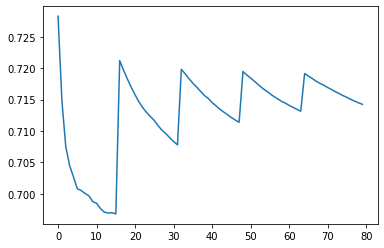

In [22]:
plt.plot(training_losses)

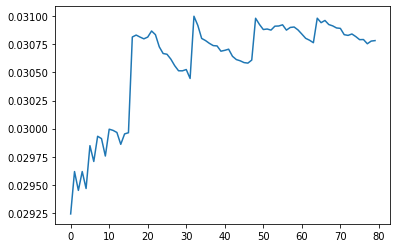

In [23]:
plt.plot(training_acc)

In [24]:
# MODEL_PATH = "/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/pytorch-model-checkpoint-2epoch-suhas.bin"
MODEL_DIR = "/root/data/BERT/uncased_L-12_H-768_A-12-pytorch/"
model_checkpoint_name="pytorch-model-checkpoint-5epoch-smalldata-thresh-0p8.bin"
# torch.save(trained_model,MODEL_PATH+model_checkpoint_name)
# Save the trained model to a file
torch.save(trained_model,MODEL_DIR+model_checkpoint_name)

In [28]:
# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = '/root/data/BERT/trained-models-balanced_data-seq_128-epoch_2-lr_2e-5/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# model = trained_model
# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
